In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319', '#242482']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

# Introduction to Classification

In this notebook, we take our first look at classification. We'll consider our first classification algorithm, called the **$k$-nearest neighbors algorithm**. We'll also think about how we measure the performance of our models using metrics such as **accuracy, precision and recall**.

Below, we'll load and normalize some data.

In [3]:
# load data from text
data = np.loadtxt('data/lec21.txt')
num_points = data.shape[0]

# Shuffle the data to remove bias with respect to order
I_perm = np.random.permutation(len(data))
data = data[I_perm, :]

# Normalized input data
x = data[:, 0:2]
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

# The class data
y = data[:, 2]

For plotting purposes -- specifically to set the colors of each of the classes to red and blue, we'll create this list of color strings. Each entry is just a hexadecimal specification of a color for a corresponding data point.

In [4]:
# turn 0,1,2 to color strings just for plotting
y_color = []
for i in range(num_points):
    y_color.append(COLORS[int(y[i])])

With this we can plot the data

Text(0, 0.5, 'x2')

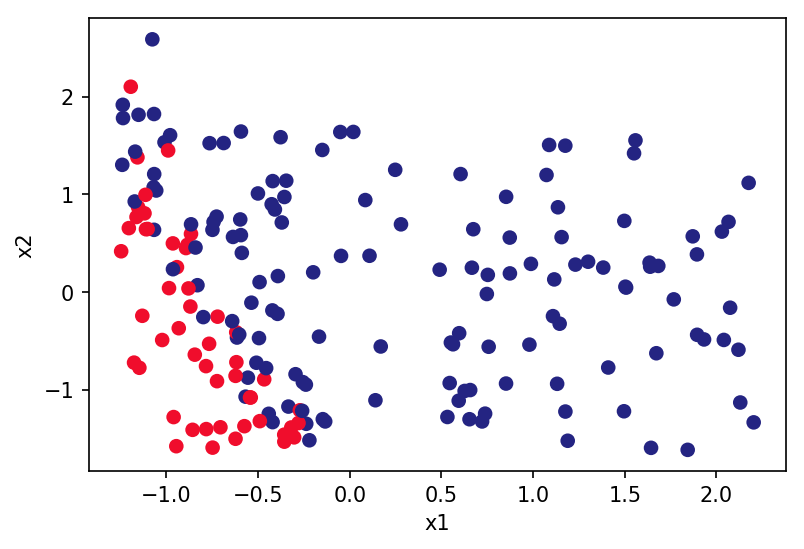

In [7]:
plt.scatter(x[:,0], x[:,1], c=y_color)
plt.xlabel('x1')
plt.ylabel('x2')

The goal of classification is to predict the class for new data inputs, $x = (x_1, x_2)$, consistent with this data. Since this data is in 2 dimensions, and we can  see the data, and it's pretty obvious how to separate the data, this example seems somewhat contrived. However, the goal is to do this for higher-dimensional data, which we can't see and so we have to rely on the computer to do the classification for us.

Again, as best practice, we should partion off train, validation and testing sets.

In [8]:
num_train = int(num_points*0.8*0.8)
num_valid = int(num_points*0.8*0.2)

x_train = x[:num_train]
y_train = y[:num_train]
    
x_valid = x[num_train:num_train+num_valid]
y_valid = y[num_train:num_train+num_valid]

x_test = x[num_train+num_valid:]
y_test = y[num_train+num_valid:]

The first classification model we'll look at is $k$-nearest neighbors (knn). To predict the class at any point $x = (x_1, x_2)$, knn looks for the $k$ closest training data points to $x$, and just takes a majority vote. The class with the highest vote is what we use to predict the class at $x$.

`scikit-learn` has the $k$-nearest neighbors classifier in `sklearn.neighbors.KNeighborsClassifier`. We use it like any other `scikit-learn` model.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Once this model has been fit, we can use it to predict the class at any point $x = (x_1, x_2)$. Below, we'll color the entire plane according to this prediction. It's ok to ignore this part, but we'll use it to visualize our results. Basically, all we do is to generate a bunch of points $(x_1, x_2)$ (Lines 6-10), predict the class of these points according to the model (line 13), and use these predictions to color the whole plane (line 16-18).

Text(0, 0.5, 'X2')

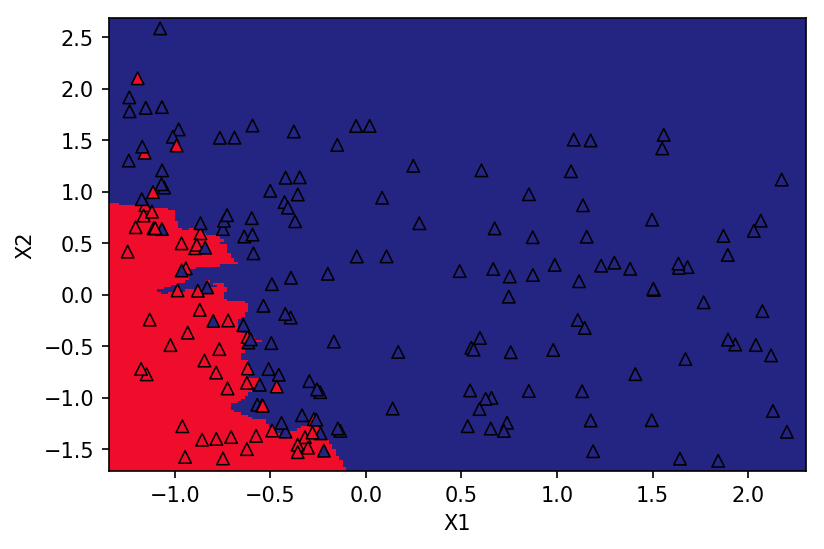

In [10]:
from matplotlib.colors import ListedColormap

# Let's predict every point in the plane - you can ignore this part if you want

# Form all combinations of points in the plane
x1_plot = np.linspace(np.min(x[:,0])-0.1, np.max(x[:, 0])+0.1, 200)
x2_plot = np.linspace(np.min(x[:,1])-0.1, np.max(x[:, 1])+0.1, 200)
xx1, xx2 = np.meshgrid(x1_plot, x2_plot)
# Flatten xx1 and xx2 to a list of points
x_plot = np.array([xx1.ravel(), xx2.ravel()]).transpose()

# classify each point
y_plot = model.predict(x_plot)

# shape into matrix so we can color the plane
y_plot = y_plot.reshape(xx1.shape)
# plot classification at each point as a colored region
plt.pcolormesh(xx1, xx2, y_plot, cmap=ListedColormap(COLORS))

# Plot the original data
plt.scatter(x[:,0], x[:,1], marker='^', edgecolors='k', linewidth=0.75, c=y_color)
plt.xlabel('X1')
plt.ylabel('X2')

Let's be more quantatative with assessing the performance of the classifier. For this, we can use one of several metrics. First, we'll just see how well we predicted the validation data.

In [11]:
y_valid_model = model.predict(x_valid)
print(y_valid_model)
print(y_valid)

[1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1.]
[0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1.]


Next we'll calculate Accuracy, Precision and Recall.

In [12]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_valid, y_valid_model)
print("Accuracy = " + str(acc))

Accuracy = 0.7931034482758621


In [13]:
from sklearn.metrics import confusion_matrix

M = confusion_matrix(y_valid, y_valid_model)
print(M)
print("")
print("TN  = " + str(M[0,0]))
print("FN  = " + str(M[1,0]))
print("TP  = " + str(M[1,1]))
print("FP  = " + str(M[0,1]))

[[ 5  3]
 [ 3 18]]

TN  = 5
FN  = 3
TP  = 18
FP  = 3


In [14]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_valid, y_valid_model)
recall = recall_score(y_valid, y_valid_model)

print("Precision = " + str(precision))
print("Recall = " + str(recall))

Precision = 0.8571428571428571
Recall = 0.8571428571428571


In [15]:
from sklearn.metrics import fbeta_score

f1_score = fbeta_score(y_valid, y_valid_model, beta = 1)
print("F1 Score = " + str(f1_score))

F1 Score = 0.8571428571428571


# Logistic Regression

Below we'll use logistic regression, which maps inputs to binary classes

$$ c = \text{sgn}(\varphi(\mathbf x) \cdot \theta).$$

where $\text{sgn}$ is the sign function and $\varphi(\mathbf x)$ is the vector of the basis function values evaluated at an input $\mathbf x$.

We need some basis functions that take in two inputs $x_1, x_2$. We'll use the monomial basis to form all degree $d$ monomials in 2 variables, and evaluate these monomials on our data to form a design matrix. Before, when we only had one input variable, we could form the analogous design matrix using the `np.vander` function, but in higher dimensions, we have to write our own. (Soon we won't have to write our own when we once again turn to kernel functions.)

In [16]:
import itertools
import scipy

# multivariate analog of np.vander - forms monomial basis design matrix
def form_design_matrix(X, k = 1):
    num_rows = X.shape[0]
    num_cols = X.shape[1]
    
    # Add a column of 1's to the set of variables
    XX = np.concatenate((np.ones([num_rows, 1]), X), axis=1)
    
    # form the list of all multivariable monomials with total degree = 1
    combinations = itertools.combinations_with_replacement(range(num_cols+1), k)
    # the number of such monomials
    num_combinations = int(scipy.special.binom(num_cols+1 + k - 1, k))
    Phi_T = np.zeros([num_combinations, num_rows])
    
    # iterate over all monomials
    for j, exp in enumerate(combinations):
        # iterate over all data points
        for i in range(num_rows):
            # apply the j-th monomial
            Phi_T[j, i] = 1
            for l in range(k):
                Phi_T[j, i] = Phi_T[j, i]*XX[i, exp[l]]
            Phi_T[j,i] = Phi_T[j,i]

    Phi = np.transpose(Phi_T)
    
    return Phi

In [17]:
n = 2

Phi_train = form_design_matrix(x_train, n)
Phi_valid = form_design_matrix(x_valid, n)

print(Phi_train.shape)

(119, 6)


Once we can form design matrices, we can use the logistic regression model in `sklearn.linear_model.LogisticRegression`

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept = False)
model.fit(Phi_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_valid_model = model.predict(Phi_valid)

acc = accuracy_score(y_valid, y_valid_model)
precision = precision_score(y_valid, y_valid_model)
recall = recall_score(y_valid, y_valid_model)
f1_score = fbeta_score(y_valid, y_valid_model, beta = 1)

print("Accuracy = " + str(acc))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 Score = " + str(f1_score))

Accuracy = 0.8620689655172413
Precision = 0.8695652173913043
Recall = 0.9523809523809523
F1 Score = 0.909090909090909


## Constant classifier

In [20]:
# list comprehension - Short-hand for for loop.
y_valid_model = [1 for _ in range(len(x_valid))]

acc = accuracy_score(y_valid, y_valid_model)
precision = precision_score(y_valid, y_valid_model)
recall = recall_score(y_valid, y_valid_model)
f1_score = fbeta_score(y_valid, y_valid_model, beta = 1)

print("Accuracy = " + str(acc))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 Score = " + str(f1_score))

Accuracy = 0.7241379310344828
Precision = 0.7241379310344828
Recall = 1.0
F1 Score = 0.8400000000000001
